In [1]:
# This is a notebook to do some basic data exploration and 
# run some bagging/boosted methods 
# on a sample data set to distinguish between Lyman Alpha Emitting 
# Galaxies and OII Emitting Galaxies.

# Author: Viviana Acquaviva

# License: BSD but really should be TBD - just be nice.

### Bagging and Boosting Methods

Random Forests and XGBoost!

In [2]:
import pandas as pd
import numpy as np
import time
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
import warnings

# Suppress warnings out of badness
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [3]:
# Helper function to make nice confusion matrices
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data import

Read the data in a data frame using pandas, take a look at them, check the size of the data set, rename columns to something easier to type.

In [4]:
# Read in the data file
data = pd.read_csv('LAE_OII_ICCUB.txt', comment='#', sep='\t')

In [5]:
# Loop at the first few rows of the data base
data.head()

,type,wavelength of EL (angstroms),EL flux (erg/cm^2/s),continuum flux density,EW observed
0,LAE,4114.6,1.787900e-16,1.0146,99.516
1,LAE,3869.9,6.304500e-17,0.2145,146.820
2,LAE,3962.6,6.446300e-17,0.2983,113.190
3,LAE,3901.7,1.007500e-16,0.0211,2424.600
4,LAE,3954.3,7.311100e-17,1.0416,36.611


In [6]:
# Look at the shape of the data
data.shape

(5436, 5)

In [7]:
# Rename the columns (there are horrid names)
data.columns = ['type', 'wave', 'ELflux', 'contflux', 'EW']

In [8]:
# Look at the first few rows again, now with new titles
data.head()

,type,wave,ELflux,contflux,EW
0,LAE,4114.6,1.787900e-16,1.0146,99.516
1,LAE,3869.9,6.304500e-17,0.2145,146.820
2,LAE,3962.6,6.446300e-17,0.2983,113.190
3,LAE,3901.7,1.007500e-16,0.0211,2424.600
4,LAE,3954.3,7.311100e-17,1.0416,36.611


In [9]:
# Pick out the unique entries of the 'type' column, demonstrating that there are only two types of object here
np.unique(data.type)

array(['LAE', 'OII'], dtype=object)

### Data exploration

Look at data properties divided by type to figure out some differences between LAEs and OIIs. Change settings to visualize all the columns in a data frame. 

In [10]:
# Only analyses numerical columns
data.describe() 

,wave,ELflux,contflux,EW
count,5436.00000,5.436000e+03,5436.000000,5436.000000
mean,4015.02660,2.449815e-16,68.686761,440.655398
std,112.44312,1.021284e-15,854.380290,3353.032457
min,3800.20000,4.276800e-17,-0.241100,0.008900
25%,3923.27500,5.849275e-17,0.208650,17.725000
50%,4018.35000,7.434850e-17,0.504750,80.634000
75%,4113.52500,1.123825e-16,2.763625,188.425000
max,4200.00000,3.426100e-14,41370.000000,157450.000000


In [11]:
# Describe makes things like mean, standard deviations, etc., etc.
data.groupby('type').describe()

ELflux                                                          \
       count          mean           std           min           25%   
type                                                                   
LAE   4415.0  8.005258e-17  3.630592e-17  4.276800e-17  5.655650e-17   
OII   1021.0  9.581660e-16  2.219254e-15  4.495600e-17  1.125200e-16   

                                                    EW               ...    \
               50%           75%           max   count        mean   ...     
type                                                                 ...     
LAE   6.891900e-17  9.028000e-17  4.380200e-16  4415.0  540.767356   ...     
OII   2.738200e-16  7.966100e-16  3.426100e-14  1021.0    7.752076   ...     

      contflux             wave                                            \
           75%      max   count         mean         std     min      25%   
type                                                                        
LAE     0.8817   2669.9  4415.0  4003.127475  112.761281  3800.2  3908.35   
OII   149.6100  41370.0  1021.0  4066.480705   95.303749  3826.2  3998.80   

                              
         50%     75%     max  
type                          
LAE   3999.6  4103.1  4200.0  
OII   4085.8  4148.2  4199.8  

[2 rows x 32 columns]

In [12]:
# See more columns
pd.set_option('display.max_columns', 500) 

In [13]:
# Describe again
data.groupby('type').describe()

ELflux                                                          \
       count          mean           std           min           25%   
type                                                                   
LAE   4415.0  8.005258e-17  3.630592e-17  4.276800e-17  5.655650e-17   
OII   1021.0  9.581660e-16  2.219254e-15  4.495600e-17  1.125200e-16   

                                                    EW              \
               50%           75%           max   count        mean   
type                                                                 
LAE   6.891900e-17  9.028000e-17  4.380200e-16  4415.0  540.767356   
OII   2.738200e-16  7.966100e-16  3.426100e-14  1021.0    7.752076   

                                                                 contflux  \
              std     min     25%       50%      75%         max    count   
type                                                                        
LAE   3713.490362  0.0304  48.295  111.1700  219.205  157450.000   4415.0   
OII      8.049062  0.0089   2.110    5.1784   10.639      69.723   1021.0   

                                                                            \
            mean          std     min      25%      50%       75%      max   
type                                                                         
LAE     3.095571    58.841667 -0.2411   0.1744   0.3545    0.8817   2669.9   
OII   352.315656  1943.049897  0.6176  11.0200  35.0440  149.6100  41370.0   

        wave                                                                    
       count         mean         std     min      25%     50%     75%     max  
type                                                                            
LAE   4415.0  4003.127475  112.761281  3800.2  3908.35  3999.6  4103.1  4200.0  
OII   1021.0  4066.480705   95.303749  3826.2  3998.80  4085.8  4148.2  4199.8

In [14]:
# Remove the percentiles
data.groupby('type').describe(percentiles=[])

ELflux                                                          \
       count          mean           std           min           50%   
type                                                                   
LAE   4415.0  8.005258e-17  3.630592e-17  4.276800e-17  6.891900e-17   
OII   1021.0  9.581660e-16  2.219254e-15  4.495600e-17  2.738200e-16   

                        EW                                             \
               max   count        mean          std     min       50%   
type                                                                    
LAE   4.380200e-16  4415.0  540.767356  3713.490362  0.0304  111.1700   
OII   3.426100e-14  1021.0    7.752076     8.049062  0.0089    5.1784   

                 contflux                                                     \
             max    count        mean          std     min      50%      max   
type                                                                           
LAE   157450.000   4415.0    3.095571    58.841667 -0.2411   0.3545   2669.9   
OII       69.723   1021.0  352.315656  1943.049897  0.6176  35.0440  41370.0   

        wave                                                   
       count         mean         std     min     50%     max  
type                                                           
LAE   4415.0  4003.127475  112.761281  3800.2  3999.6  4200.0  
OII   1021.0  4066.480705   95.303749  3826.2  4085.8  4199.8

Plot some interesting property for the two classes

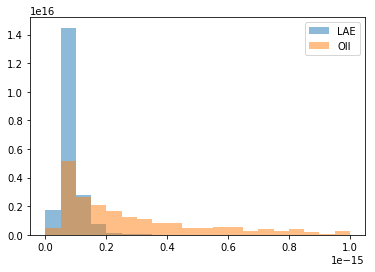

In [15]:
# Plot some histograms
plt.hist(data[data.type == 'LAE']['ELflux'], bins = 20, alpha = 0.5, label = 'LAE', range=(0,1e-15), density=True);
plt.hist(data[data.type == 'OII']['ELflux'], bins = 20, alpha = 0.5, label = 'OII', range=(0,1e-15), density=True);
plt.legend();

Look for / eliminate outliers of chosen significance

In [16]:
# Some sort of sigma clipping
seldata = data[(np.abs(stats.zscore(data.drop(['type'], axis=1))) < 4. ).all(axis=1)] # fill

In [17]:
# See how many objects have been deleted
print('Original shape:', data.shape)
print('Selected shape:', seldata.shape)
print('Number of deleted:', data.shape[0]-seldata.shape[0])

Original shape: (5436, 5)
Selected shape: (5372, 5)
Number of deleted: 64


Take another look at new data

In [18]:
# Look at the clipped data to see if properties have changed
seldata.groupby('type').describe(percentiles = [])

ELflux                                                          \
       count          mean           std           min           50%   
type                                                                   
LAE   4408.0  8.007443e-17  3.632968e-17  4.276800e-17  6.892650e-17   
OII    964.0  5.955074e-16  8.420538e-16  4.495600e-17  2.503300e-16   

                        EW                                             \
               max   count        mean          std     min       50%   
type                                                                    
LAE   4.380200e-16  4408.0  421.610226  1528.146124  0.0304  111.0350   
OII   4.220100e-15   964.0    7.874112     8.091065  0.0394    5.4424   

                contflux                                                   \
            max    count        mean         std     min      50%     max   
type                                                                        
LAE   13448.000   4408.0    3.100486   58.888250 -0.2411   0.3551  2669.9   
OII      69.723    964.0  136.253722  305.958507  0.6176  31.5420  3019.5   

        wave                                                    
       count         mean         std     min      50%     max  
type                                                            
LAE   4408.0  4003.113022  112.755916  3800.2  3999.55  4200.0  
OII    964.0  4070.097510   93.028416  3826.2  4089.00  4199.8

### Transform pandas data frame into a numpy array that can be fed to sklearn methods, create feature and target arrays, and standardize (not necessary for tree-based).

In [19]:
# Not quite sure what a label encoder is
le = LabelEncoder()

In [20]:
# Transform label into array of 0, 1, ...
newcol = le.fit_transform(seldata['type'])

In [21]:
newcol

array([0, 0, 0, ..., 1, 0, 0])

In [22]:
# Note: this assigns the positive '1' (OII) and negative '0' (LAE) class! 
# Need to check and if necessary, flip.
seldata.ix[:,'type'] = newcol

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
seldata.head()

,type,wave,ELflux,contflux,EW
0,0,4114.6,1.787900e-16,1.0146,99.516
1,0,3869.9,6.304500e-17,0.2145,146.820
2,0,3962.6,6.446300e-17,0.2983,113.190
3,0,3901.7,1.007500e-16,0.0211,2424.600
4,0,3954.3,7.311100e-17,1.0416,36.611


Arrange data in feature matrix and target vector

In [24]:
# Here X are the features, which is everything except the 'type', which is the label
X, y = seldata.drop(['type'], axis=1), seldata['type']

In [25]:
# Write out X again just to check what it looks like
X

,wave,ELflux,contflux,EW
0,4114.6,1.787900e-16,1.0146,99.5160
1,3869.9,6.304500e-17,0.2145,146.8200
2,3962.6,6.446300e-17,0.2983,113.1900
3,3901.7,1.007500e-16,0.0211,2424.6000
4,3954.3,7.311100e-17,1.0416,36.6110
5,3896.6,5.990100e-16,18.7050,16.2200
6,4108.6,1.456500e-15,284.1400,2.8862
7,4098.2,2.862100e-15,205.8200,7.7904
8,4079.0,1.019300e-16,1.7645,32.0610
9,3900.4,8.694700e-17,1.2852,34.3300


In [26]:
# Force the features to be mean 0 with std 1 (generally a good idea)
normalized_X = (X - X.mean())/X.std()

In [27]:
# Check that the normalisation has worked
normalized_X.describe()

,wave,ELflux,contflux,EW
count,5.372000e+03,5.372000e+03,5.372000e+03,5.372000e+03
mean,1.874698e-14,1.066079e-15,-4.814549e-16,-4.364838e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.911408e+00,-3.173040e-01,-1.826279e-01,-2.492874e-01
25%,-8.142309e-01,-2.792533e-01,-1.796220e-01,-2.355986e-01
50%,2.860602e-02,-2.409875e-01,-1.776826e-01,-1.905622e-01
75%,8.765564e-01,-1.513078e-01,-1.640867e-01,-1.135303e-01
max,1.644025e+00,9.894410e+00,2.006605e+01,9.402510e+00


In [28]:
# What does this do?
scaler = StandardScaler()
scaler.fit_transform(X)

array([[ 0.88464251,  0.01521053, -0.17422407, -0.17790178],
       [-1.29168452, -0.26776072, -0.17958958, -0.14394787],
       [-0.46722389, -0.26429402, -0.17902762, -0.16808685],
       ...,
       [ 1.53300475,  2.00616736,  0.65528449, -0.24598897],
       [-1.54160192, -0.13079183, -0.16943527, -0.22499252],
       [ 0.58936643, -0.24247923, -0.17356352, -0.223038  ]])

Use standard scaler, robust scaler

## Ensemble Method 1: Random Forests

Let's start with a RF Classifier with standard parameters, using cross_val_score and cross_val_predict.

In [29]:
# Setup the model
model = RandomForestClassifier()

In [30]:
# Cross-validation scheme
cv = StratifiedKFold(shuffle=True, n_splits=10, random_state=7)

In [31]:
# Choose scoring system
scores = cross_val_score(model, normalized_X, y, cv=cv, scoring='recall')

In [32]:
# Print the scores, the mean and standard deviation across all splits
scores.mean(), scores.std()

(0.8381335910652921, 0.03604077483537535)

In [33]:
# Try other scoring params?
scores = cross_val_score(model, normalized_X, y, cv=cv, scoring='accuracy')

In [34]:
# Print the scores
scores.mean(), scores.std()

(0.9475057631201844, 0.008717055083468471)

In [35]:
# Try other scoring params?
scores = cross_val_score(model, normalized_X, y, cv=cv, scoring='precision')

In [36]:
# Print the scores
scores.mean(), scores.std()

(0.854547574762765, 0.029066054748051864)

In [37]:
# Build one realization of predictions with cross_val_predict
ypred = cross_val_predict(model, normalized_X, y, cv=cv)

Confusion matrix, without normalization


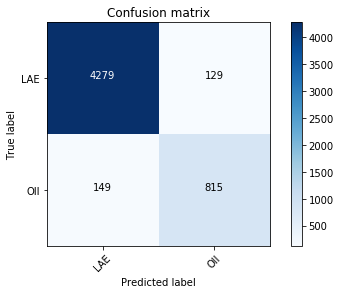

In [38]:
# Visualize and plot the confusion matrix.
cm = metrics.confusion_matrix(y, ypred)
plot_confusion_matrix(cm, classes = ['LAE','OII'])

### We can look at the ROC/AUC by using the "predict_proba" feature.

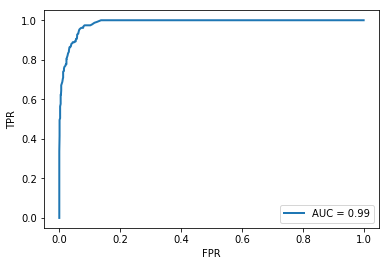

In [39]:
#I need to call "fit" explicitly to do this, so I am defining a train/test split

#Inspired by https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

Xtrain, Xtest, ytrain, ytest = train_test_split(normalized_X, y, random_state=5)

probas = model.fit(Xtrain, ytrain).predict_proba(Xtest) #doing only on one fold

# Compute ROC curve and area under the curve

fpr, tpr, thresholds = metrics.roc_curve(ytest, probas[:, 1])

roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

Question: What's not kosher about the above?

Only one split, one should average this over all kfolds

### Feature ranking

After the model has been fit, it will have the attribute "feature\_importances\_". We can look at the feature importance using the following code:

In [40]:
# note: this is not doing any train/test split, but fitting the entire data set 
model.fit(normalized_X,y) 
model.feature_importances_

array([0.0925462 , 0.21032439, 0.44058147, 0.25654794])

The code below plots the feature importances.

Feature ranking:
1. feature: contflux, 2 (0.440581)
2. feature: EW, 3 (0.256548)
3. feature: ELflux, 1 (0.210324)
4. feature: wave, 0 (0.092546)


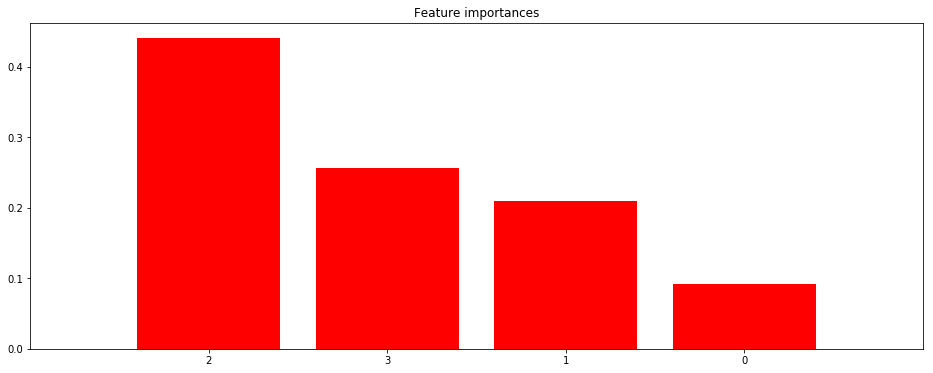

In [41]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(normalized_X.shape[1]):
    print("%d. feature: %s, %d (%f)" % (f + 1, normalized_X.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(normalized_X.shape[1]), indices)
plt.xlim([-1, normalized_X.shape[1]])
plt.show()

We need to take it with a grain of salt (especially when we have only a few) because information is often split if features are not independent.

### How to improve?

In [42]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Tree Parameters

The parameters associated to that are:

-  The minimum number of instances in a leaf node;

-  The minimum number of instances required in a split node;

- The maximum depth of tree.

-  The criterion chosen to decide whether a split is "worth it", expressed in terms of information gain;


#### Randomization Parameters

- The number of k < n features that are used in building trees.

- The re-sampling (boostrap) of the data set


#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.

<b> TASKS (15 minutes) </b> 

-  Play with your favorite parameters to see if you can beat the benchmark performance above.

-  Now do the same thing, but using recall as your scoring method.

In [43]:
model = RandomForestClassifier(max_depth=1, 
                               min_impurity_decrease=0.1, 
                               min_samples_leaf=10, 
                               min_samples_split=10,
                               n_estimators=100,
                               random_state=5
                              )

# Cross-validation scheme
cv = StratifiedKFold(shuffle=True, n_splits=10, random_state=7)

# Choose scoring system
scores = cross_val_score(model, normalized_X, y, cv=cv, scoring='recall')

# Print the scores
scores.mean(), scores.std()

(0.8444372852233677, 0.03016955053236227)

In [44]:
# Viviana's solution involving a loop
cvmethod = StratifiedKFold(n_splits=8, shuffle =True)
parameters = {'max_depth':[3,5,8], \
              'max_features': [2,4], 
              'n_estimators':[10,20,50],
              'class_weight':[{1:1},{1:3},{1:5}]}
nmodels = np.product([len(el) for el in parameters.values()])

In [45]:
model = GridSearchCV(RandomForestClassifier(), 
                     parameters, 
                     cv = cvmethod,
                     scoring = 'recall',
                     verbose = 1, 
                     n_jobs = 4
                    )
start = time.time()
model.fit(normalized_X, y)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 8 folds for each of 54 candidates, totalling 432 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 432 out of 432 | elapsed:   26.2s finished


Best params, best score: 0.9689 {'class_weight': {1: 5}, 'max_depth': 3, 'max_features': 2, 'n_estimators': 50}
Time per model (s): 0.1222


### Ensemble methods 2: Gradient Boosting Models

Gradient Boosting models are another ensemble method where weak learners (usually decision stumps) are combined together.

Unlike Random Forests, the model is built by <b> adding individual trees in a sequential fashion, </b>
but choosing which trees we add to the model in a way that minimizes the current loss function. The "Gradient" part refers to the fact that we try to move along the gradient of the objective function (by calculating its numerical derivative) as we add more trees.

The parameters depend on the particular implementation.

In the sklearn formulation, the parameters of each tree are essentially the same we saw above; additionally we have the "learning_rate" parameter, which dictates how much each tree contribute to the final estimator, and the "subsample" parameters, which allows one to use a < 1.0 fraction of samples.

I liked this blog post about parameter tuning for GBMs:

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

#### We'll do the usual benchmarking with cross_val_score and check differences with RF:

In [46]:
# Setup the gradient boosing model and the cross-validation scheme as normal
model2 = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=8, shuffle=True)
scores2 = cross_val_score(model2, normalized_X, y, cv=cv, scoring='recall')
scores2.mean(), scores2.std()

(0.8506112258953168, 0.02036927777735932)

<b> TASKS (10 minutes) </b>

-  Use the get_params() method to find out the names and signatures of different parameters, and their default values.

-  Play with your favorite parameters to see how much you can improve the benchmark performance above.

-  Compare the timings to Random Forests.

In [47]:
# Look at the parameters of the model
model2.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [48]:
# Mead's solution
model2 = GradientBoostingClassifier(max_depth=3, learning_rate=0.05, min_samples_split=2, n_estimators=100)
cv = StratifiedKFold(n_splits=8, shuffle=True)
scores2 = cross_val_score(model2, normalized_X, y, cv=cv, scoring='recall')
print('Mean:', scores2.mean())
print('Standard deviation:', scores2.std())
model2.get_params()

Mean: 0.8515754132231406
Standard deviation: 0.025852820268509522


{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [49]:
# Viviana's solution involving a loop
cvmethod = StratifiedKFold(n_splits=8, shuffle =True)
parameters = {'max_depth':[2, 3, 4],
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators':[50, 100, 200],
             }
nmodels = np.product([len(el) for el in parameters.values()])

In [50]:
model = GridSearchCV(GradientBoostingClassifier(), 
                     parameters,
                     cv = cvmethod,
                     scoring = 'recall',
                     verbose = 1, 
                     n_jobs = 4,
                     return_train_score = True,
                    )
start = time.time()
model.fit(normalized_X, y)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 8 folds for each of 27 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.4s
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:   55.2s finished


Best params, best score: 0.8557 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Time per model (s): 0.5186


### Subtleties in parameter optimization and data processing (we'll see some next week)

-  Use cv_results to look at gradients along parameters and build understanding;

-  Push the edges of your parameter grid search; 

-  One needs to do nested cross validation (we'll see next week) to evaluate the generalization error in order to avoid leakage between the parameter optimization and the cross validation procedure. 

- Technically, standardizing/normalizing data using the entire learning set introduces leakage between train and test set (the test set "knows" about the mean and standard deviation of the entire data set). Usually not dramatic, but the correct procedure is to do it within each CV fold (i.e. after separating in train and test), only on the train set, and applying the same transformation to the test set. The model then becomes a pipeline.

- Technically, doing feature selection using the entire learning set introduces leakage between train and test set (the model "picks" features that give the best results on the test set). The solution is to pick the "average" best features within the CV model, which is effectively what happened here. Scores will still need to be evaluated using nested cross validation (next week). In alternative, one can use unsupervised methods, for example pick features with the largest variance; this is ok because it doesn't involve labels.

### My advice: Define your own evaluation metric 

This is an example of what we did for this paper (Leung, VA et al 2016), where x0 = 1 - precision and x1 = 1 - recall.

<img src="Formula_Leung.jpg" width="300"/>


#### How to do that in code?

In [51]:
from sklearn.metrics import make_scorer

In [52]:
def my_loss_func(y, ypred):
    return np.log(1+np.abs(y-ypred).max())

In [53]:
model = RandomForestClassifier()

In [54]:
cross_val_score(model, normalized_X, y, 
                cv=cvmethod, \
                scoring=make_scorer(my_loss_func, greater_is_better=False)
               )

array([-0.69314718, -0.69314718, -0.69314718, -0.69314718, -0.69314718,
       -0.69314718, -0.69314718, -0.69314718])

### Summary

Take a look at your data before you start building models.

Which algorithm is best, and how you will optimize it, really depends on what you are trying to do.

Define your own evaluation metric and/or pick the one that works best for your problem and your data.

### Exercises :) 

### 1. Try out xgboost (vs sklearn's gradient boosting method)

Sometimes knowns as "regularized" gradient boosting method, more robust to overfitting.

Has more flexibility in defining weak learners, and objective function.

Reputation of being very fast.

From the same author as the one above:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
import xgboost

In [ ]:
model = xgboost.XGBClassifier()

In [ ]:
model.get_params()

### 2. Try out HistGradientBoostingClassifier 

(sklearn's newest implementation, inspired by Microsoft's LightGBM. Promises to be super fast
on large ( > 10,000) data sets, by turning numerical features into bins to limit the number of possible splits. Requires installing sklearn v 0.21.x).



In [ ]:
#This is the starter code

# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier


### 3. Compare DT, RF, GBM on same data set (either this one, or variable stars).

Compare performance of RF, GBM to DT out of the box for the variable star data set. Are ensemble methods effective in reducing overfitting?

Note: if you'd like, you can use this handy function "checktraintest" that I wrote to evaluate the difference between train and test scores in a "cross-validate-y" fashion. The standard deviation helps determine if the difference is statistically significant.

In alternative, one can use sklearn "cross_validate" function with the option return_train_score = T.

In [ ]:
def checktraintest(X, y, model, ntrials =5, test_size = 0.2):
    
    """evaluates the difference between a classifier's train and test scores 
    in a "k-fold-y" fashion. Output means and std to help determine if 
    the difference is statistically significant. """

    scores_train = np.zeros(ntrials)
    scores_test = np.zeros(ntrials)

    for i in range(ntrials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size, random_state=i)
        model.fit(X_train, y_train)
        pred_test = model.predict(X_test)
        pred_train = model.predict(X_train)

        scores_test[i] = (metrics.accuracy_score(y_test,pred_test))
        scores_train[i] =(metrics.accuracy_score(y_train,pred_train))

    print('Training scores '+str(scores_train.mean())+' +- '+str(scores_train.std()))
    print('Test scores '+str(scores_test.mean())+' +- '+str(scores_test.std()))